# README

- **Author**: `方珮潔`
- **Created At**: `2025-10-12`
- **Last Modified At**: `2025-10-31`

---

## What does this file do?

程式根據以下步驟生成「探討非固定折扣遊戲的折扣幅度影響因子」所需數據：
- `資料檢查與前處理`
  - `前置作業`
  - `結合兩張資料表`
  - `資料表形狀與前五列`
  - `刪除折扣幅度固定的遊戲`
  - `資料型態與缺失值`
  - `刪除 Players、Followers 數值異常的遊戲`
  - `數值欄位分佈`
  - `類別欄位分佈`
- `進階欄位生成`
  - `折扣率`
  - `遊戲年齡`
  - `累積評價正面率`
  - `是否為平台促銷期`
  - `玩家數、追蹤人數、正面率的指定期間增長率`
  - `欄位生成結果統整`
- `將列改為折扣事件導向`
- `結果檔案整理`
  - `刪除不需欄`
  - `欄位順序調整`
  - `篩選所需時間範圍`
  - `欄位型態調整`
  - `結果檔案觀察`
- `輸出結果檔案：extent-of-discount-rate-DE.ipynb`

---

## What does this file take?

- **Source Data Sets**:  
  1. `all_games_merged.csv` 
    - Description: `來自 merge-data-processing-code.ipynb 處理完的資料，欄位包含：` 
      - Players
      - Date
      - Final price
      - Followers
      - Positive reviews
      - Negative reviews
      - DiscountDuration
      - GameID
      - ReleaseDate
      - OriginPrice
      - Type
      - MultiPlayer
      - Publisher
      - ConstantDiscount
  2. `release_events_all_games.csv`
    - Description: `額外整理每個遊戲推出新 DLC 及續作的時間點，欄位包含：`
      - GameID
      - Date
      - Has_DLC
      - Has_Sequel
---

## What does this file output?

- `processed_data.csv`  
  - Description: `包含所有 DA 所需分析折扣大小的完整資料表，欄位包含：`
    - Date
    - GameID
    - Type
    - MultiPlayer
    - Publisher
    - ConstantDiscount
    - DiscountRate
    - DiscountDuration
    - Age
    - AccumulatedPositiveRate
    - SalePeriod
    - PlayerGrowthRate1W
    - PlayerGrowthRate2W
    - PlayerGrowthRate1M
    - FollowersGrowthRate1W
    - FollowersGrowthRate2W
    - FollowersGrowthRate1M
    - PositiveRateGrowthRate1W
    - PositiveRateGrowthRate2W
    - PositiveRateGrowthRate1M
    - DLC_since_last_discount
    - Sequel_since_last_discount



# 程式碼

## 資料檢查與前處理

### 前置作業

In [120]:
# 後續所需套件引入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# 顯示所有欄與列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 增加螢幕寬度
pd.set_option('display.width', 2000)

# 若欄位名稱太長也不截斷
pd.set_option('display.max_colwidth', None)

In [122]:
# 地端資料表讀取
all_games_df = pd.read_csv("/Users/peijiefang/Downloads/data analysis project/all_games_merged.csv") 
release_events_df = pd.read_csv("/Users/peijiefang/Downloads/data analysis project/release_events_all_games.csv")

### 結合兩張資料表

In [123]:
merged_df = pd.merge(all_games_df, release_events_df, on=['GameID', 'Date'], how='left')

# 把缺失值補成 0
merged_df['Has_DLC'] = merged_df['Has_DLC'].fillna(0)
merged_df['Has_Sequel'] = merged_df['Has_Sequel'].fillna(0)

df = merged_df.copy()

### 資料表形狀與前五列

In [124]:
# 資料表形狀
print("\n--- Shape ---")
print(df.shape)

# 資料表前五列
print("\n--- Head 5 rows ---")
df.head()


--- Shape ---
(29247, 16)

--- Head 5 rows ---


Players        Date  Final price  Followers  Positive reviews  Negative reviews  DiscountDuration  GameID ReleaseDate  OriginPrice    Type  MultiPlayer              Publisher  ConstantDiscount  Has_DLC  Has_Sequel
0  122237.0  2023-01-01        120.0     927415            587533            -11350                 0  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
1  130721.0  2023-01-02        120.0     928018            588748            -11353                 0  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
2  129769.0  2023-01-03        120.0     928691            589351            -11368                 0  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
3  129385.0  2023-01-04        120.0     929333            589351            -11368                 0  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
4  129933.0  2023-01-05        120.0     930028            589351            -11368                 0  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0

### 刪除折扣幅度固定的遊戲

In [125]:
# 找出 TargetColumn == 1 的遊戲 ID
games_to_drop = df.loc[df['ConstantDiscount'] == 1, 'GameID'].unique()

# 刪除這些遊戲的所有列
df = df[~df['GameID'].isin(games_to_drop)]

### 資料型態與缺失值

In [126]:
# 資料型態與缺失狀況
print("\n--- Data information ---")
df.info()


--- Data information ---
<class 'pandas.core.frame.DataFrame'>
Index: 23395 entries, 975 to 29246
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Players           23213 non-null  float64
 1   Date              23395 non-null  object 
 2   Final price       23395 non-null  float64
 3   Followers         23395 non-null  int64  
 4   Positive reviews  23395 non-null  int64  
 5   Negative reviews  23395 non-null  int64  
 6   DiscountDuration  23395 non-null  int64  
 7   GameID            23395 non-null  int64  
 8   ReleaseDate       23395 non-null  object 
 9   OriginPrice       23395 non-null  int64  
 10  Type              23395 non-null  object 
 11  MultiPlayer       23395 non-null  int64  
 12  Publisher         23395 non-null  object 
 13  ConstantDiscount  23395 non-null  int64  
 14  Has_DLC           23395 non-null  float64
 15  Has_Sequel        23395 non-null  float64
dtypes: float64(4), in

In [127]:
# 特定欄位資料型態轉換
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')
df['GameID'] = df['GameID'].astype(str)

# 剩餘數值欄位轉為 float 或 int
cat_cols = df.select_dtypes(include=['object', 'category']).columns
exclude_cols = list(cat_cols) + ['Date', 'ReleaseDate']
num_cols = df.columns.difference(exclude_cols)
for col in num_cols:
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(f"欄位 {col} 轉換失敗: {e}")
df['MultiPlayer'] = df['MultiPlayer'].astype(int)
df['ConstantDiscount'] = df['ConstantDiscount'].astype(int)
df['Has_DLC'] = df['Has_DLC'].astype(int)
df['Has_Sequel'] = df['Has_Sequel'].astype(int)
df['DiscountDuration'] = df['DiscountDuration'].astype(int)

# 驗證型態轉換結果
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23395 entries, 975 to 29246
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Players           23213 non-null  float64       
 1   Date              23395 non-null  datetime64[ns]
 2   Final price       23395 non-null  float64       
 3   Followers         23395 non-null  float64       
 4   Positive reviews  23395 non-null  float64       
 5   Negative reviews  23395 non-null  float64       
 6   DiscountDuration  23395 non-null  int64         
 7   GameID            23395 non-null  object        
 8   ReleaseDate       23395 non-null  datetime64[ns]
 9   OriginPrice       23395 non-null  float64       
 10  Type              23395 non-null  object        
 11  MultiPlayer       23395 non-null  int64         
 12  Publisher         23395 non-null  object        
 13  ConstantDiscount  23395 non-null  int64         
 14  Has_DLC           23395 n

In [128]:
# 設定成索引
df = df.set_index('Date')

# 缺失值補值
df['Players'] = df['Players'].interpolate(method='time')

# 後續還要用 Date 當欄位
df = df.reset_index()

In [129]:
# 再次檢查缺失狀況
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23395 entries, 0 to 23394
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              23395 non-null  datetime64[ns]
 1   Players           23395 non-null  float64       
 2   Final price       23395 non-null  float64       
 3   Followers         23395 non-null  float64       
 4   Positive reviews  23395 non-null  float64       
 5   Negative reviews  23395 non-null  float64       
 6   DiscountDuration  23395 non-null  int64         
 7   GameID            23395 non-null  object        
 8   ReleaseDate       23395 non-null  datetime64[ns]
 9   OriginPrice       23395 non-null  float64       
 10  Type              23395 non-null  object        
 11  MultiPlayer       23395 non-null  int64         
 12  Publisher         23395 non-null  object        
 13  ConstantDiscount  23395 non-null  int64         
 14  Has_DLC           2339

### 刪除 Players、Followers 數值異常的遊戲

In [130]:
df = df[~df['GameID'].isin(['331790', '423710'])]

### 數值欄位分佈

In [131]:
print("\n--- Numerical Summary ---")
df[num_cols].describe().T


--- Numerical Summary ---


count           mean            std       min       25%       50%       75%        max
ConstantDiscount  21447.0       0.000000       0.000000       0.0       0.0       0.0       0.0        0.0
DiscountDuration  21447.0       3.552432       8.375242       0.0       0.0       0.0       0.0       86.0
Final price       21447.0     388.032918     289.443828       0.0     238.0     318.0     408.0     1599.0
Followers         21447.0  556457.903576  559179.449740   30234.0  238101.0  346091.0  711684.0  2744924.0
Has_DLC           21447.0       0.000793       0.028144       0.0       0.0       0.0       0.0        1.0
Has_Sequel        21447.0       0.000187       0.013656       0.0       0.0       0.0       0.0        1.0
MultiPlayer       21447.0       0.545484       0.497938       0.0       0.0       1.0       1.0        1.0
Negative reviews  21447.0  -21816.461836   37991.807862 -174531.0  -16337.5   -7856.0   -4637.5      -86.0
OriginPrice       21447.0     454.862545     300.377865     186.0     318.0     379.0     438.0     1599.0
Players           21447.0   17114.884786   22067.763651    1518.0    4230.0    8066.0   21757.5   274526.0
Positive reviews  21447.0  252774.312025  261927.014390   12286.0   70556.0  132707.0  320531.5  1138939.0

### 類別欄位分佈


--- Categorical Summary ---

Value counts for GameID:
GameID
381210     976
477160     976
588650     976
413150     975
703080     975
644930     975
431730     975
244850     975
548430     975
242760     975
233860     975
1145360    975
880940     975
4000       975
108600     975
1091500    975
244210     974
323190     974
457140     974
582660     974
881100     974
10         974
Name: count, dtype: int64


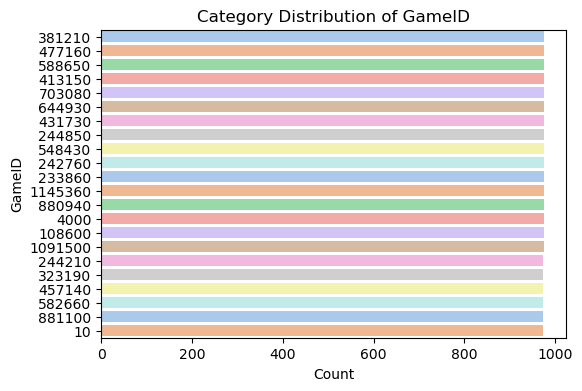


Value counts for Type:
Type
Sandbox                      2924
Horror                        976
Co-op                         976
Adventure                     976
Farming Sim                   975
Management                    975
Base Building                 975
Pixel Graphics                975
Dwarf                         975
Open World Survival Craft     975
Open World                    975
Action Roguelike              975
Funny                         975
Survival                      975
Cyberpunk                     975
Racing                        974
Colony Sim                    974
City Builder                  974
Physics                       974
Action                        974
Name: count, dtype: int64


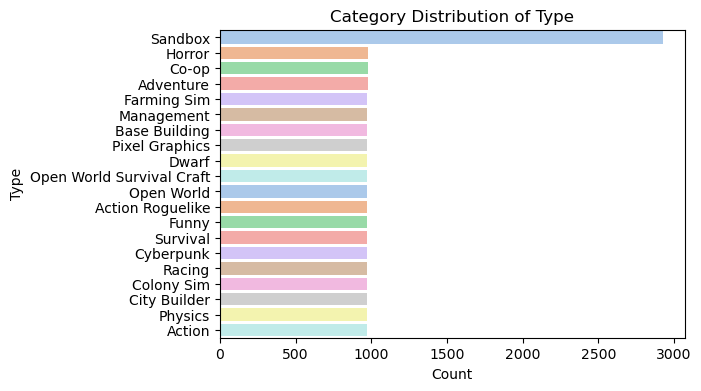


Value counts for Publisher:
Publisher
Valve                         1949
Curve Games                    976
Motion Twin                    976
Behaviour Interactive Inc.     976
ConcernedApe                   975
Endnight Games Ltd             975
Frontier Developments          975
Numantian Games                975
Igara Studio                   975
Keen Software House            975
Coffee Stain Publishing        975
Lo-Fi Games                    975
Supergiant Games               975
Rebuilt Games                  975
The Indie Stone                975
CD PROJEKT RED                 975
Klei Entertainment             974
11 bit studios                 974
Pearl Abyss                    974
Nolla Games                    974
Kunos Simulazioni              974
Name: count, dtype: int64


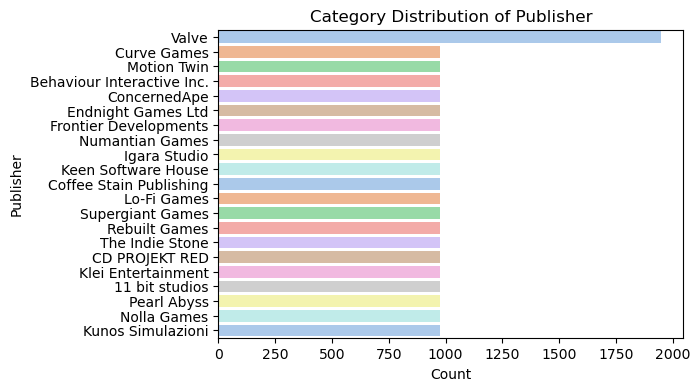

In [132]:
print("\n--- Categorical Summary ---")
for col in cat_cols[:]:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette="pastel")
    plt.title(f"Category Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()

In [133]:
cleaned_df = df.copy()

## 進階欄位生成

### 折扣率

In [134]:
# 折扣率 = （原價 - 當下價格）/ 原價，因此為折扣率為正表示降價
cleaned_df['DiscountRate'] = (cleaned_df['OriginPrice'] - cleaned_df['Final price']) / cleaned_df['OriginPrice']

### 遊戲年齡

In [135]:
# 遊戲年齡（年） = 當下日期 - 推出日期
cleaned_df['Age'] = (cleaned_df['Date'] - cleaned_df['ReleaseDate']).dt.days / 365

### 累積評價正面率

In [136]:
cleaned_df['AccumulatedPositiveRate'] = cleaned_df['Positive reviews'] / (cleaned_df['Positive reviews'] - cleaned_df['Negative reviews'])

# cleaned_df['Positive reviews on that day'] = cleaned_df['Positive reviews'] - cleaned_df['Positive reviews'].shift(1)
# cleaned_df['Negative reviews on that day'] = cleaned_df['Negative reviews'] - cleaned_df['Negative reviews'].shift(1)

### 是否為平台促銷期

In [137]:
# 建立促銷期間表
steam_sales = pd.DataFrame({
    'sale_name': [
        'Summer Sale 2023', 'Halloween Sale 2023', 'Autumn Sale 2023', 'Winter Sale 2023',
        'Lunar New Year Sale 2024', 'Spring Sale 2024', 'Summer Sale 2024', 'Autumn Sale 2024', 'Winter Sale 2024',
        'Lunar New Year Sale 2025', 'Spring Sale 2025'
    ],
    'start_date': pd.to_datetime([
        '2023-06-29', '2023-10-26', '2023-11-21', '2023-12-21',
        '2024-02-06', '2024-03-14', '2024-06-27', '2024-11-27', '2024-12-19',
        '2025-01-26', '2025-03-13'
    ]),
    'end_date': pd.to_datetime([
        '2023-07-13', '2023-11-02', '2023-11-28', '2024-01-04',
        '2024-02-15', '2024-03-21', '2024-07-11', '2024-12-04', '2025-01-02',
        '2025-02-09', '2025-03-20'
    ])
})

# 新增欄位，預設為 0
cleaned_df['SalePeriod'] = 0

# 逐一比對促銷期間
for _, row in steam_sales.iterrows():
    mask = (cleaned_df['Date'] >= row['start_date']) & (cleaned_df['Date'] <= row['end_date'])
    cleaned_df.loc[mask, 'SalePeriod'] = 1

### 玩家數、追蹤人數、正面率的指定期間移動平均增長率

In [138]:
def process_all_games(df):
    def process_game(group):
        group = group.sort_values('Date')
        group.set_index('Date', inplace=True)
        
        # players 的移動平均
        group['AvgPlayers1W'] = group['Players'].rolling(window='7D').mean()
        group['AvgPlayers2W'] = group['Players'].rolling(window='14D').mean()
        group['AvgPlayers1M'] = group['Players'].rolling(window='30D').mean()
        # players MA 增長率
        group['PlayerGrowthRate1W'] = group['AvgPlayers1W'].pct_change(periods=7)
        group['PlayerGrowthRate2W'] = group['AvgPlayers2W'].pct_change(periods=14)
        group['PlayerGrowthRate1M'] = group['AvgPlayers1M'].pct_change(periods=30)  

        # followers 增長率
        group['FollowersGrowthRate1W'] = group['Followers'].pct_change(periods=7)
        group['FollowersGrowthRate2W'] = group['Followers'].pct_change(periods=14)
        group['FollowersGrowthRate1M'] = group['Followers'].pct_change(periods=30)

        group['PositiveRateGrowthRate1W'] = group['AccumulatedPositiveRate'].pct_change(periods=7)
        group['PositiveRateGrowthRate2W'] = group['AccumulatedPositiveRate'].pct_change(periods=14)
        group['PositiveRateGrowthRate1M'] = group['AccumulatedPositiveRate'].pct_change(periods=30)

        # positive reviews 
        # group['PositiveReview1W'] = group['Positive reviews on that day'].rolling(window='7D').sum()
        # group['NegativeReview1W'] = group['Negative reviews on that day'].rolling(window='7D').sum()
        # group['PositiveReview2W'] = group['Positive reviews on that day'].rolling(window='14D').sum()
        # group['NegativeReview2W'] = group['Negative reviews on that day'].rolling(window='14D').sum()
        # group['PositiveReview1M'] = group['Positive reviews on that day'].rolling(window='30D').sum()
        # group['NegativeReview1M'] = group['Negative reviews on that day'].rolling(window='30D').sum()
        # positive reviews 的移動平均
        # group['PositiveRate1W'] = np.where(
            # group['PositiveReview1W'] - group['NegativeReview1W'] == 0,
            # 0, 
            # group['PositiveReview1W'] / (group['PositiveReview1W'] - group['NegativeReview1W'])
        # )       
        # group['PositiveRate2W'] = np.where(
            # group['PositiveReview2W'] - group['NegativeReview2W'] == 0,
            # 0, 
            # group['PositiveReview2W'] / (group['PositiveReview2W'] - group['NegativeReview2W'])
        # )
        # group['PositiveRate1M'] = np.where(
            # group['PositiveReview1M'] - group['NegativeReview1M'] == 0,
            # 0, 
            # group['PositiveReview1M'] / (group['PositiveReview1M'] - group['NegativeReview1M'])
        # )
        # positive reviews MA 增長率
        # group['PositiveRateGrowthRate1W'] = group['PositiveRate1W'].pct_change(periods=7)
        # group['PositiveRateGrowthRate2W'] = group['PositiveRate2W'].pct_change(periods=14)
        # group['PositiveRateGrowthRate1M'] = group['PositiveRate1M'].pct_change(periods=30)

        return group

    result = cleaned_df.groupby('GameID', group_keys=False).apply(process_game).reset_index()
    return result

In [139]:
gen_cols_df = process_all_games(cleaned_df)

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_39962/3684565000.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = cleaned_df.groupby('GameID', group_keys=False).apply(process_game).reset_index()


### 欄位生成結果統整

In [140]:
# 確認欄位生成狀況
gen_cols_df.head()

Date  Players  Final price  Followers  Positive reviews  Negative reviews  DiscountDuration GameID ReleaseDate  OriginPrice    Type  MultiPlayer Publisher  ConstantDiscount  Has_DLC  Has_Sequel  DiscountRate        Age  AccumulatedPositiveRate  SalePeriod  AvgPlayers1W  AvgPlayers2W  AvgPlayers1M  PlayerGrowthRate1W  PlayerGrowthRate2W  PlayerGrowthRate1M  FollowersGrowthRate1W  FollowersGrowthRate2W  FollowersGrowthRate1M  PositiveRateGrowthRate1W  PositiveRateGrowthRate2W  PositiveRateGrowthRate1M
0 2023-01-01  14817.0        186.0   194409.0          207951.0           -5310.0                 0     10  2000-11-01        186.0  Action            1     Valve                 0        0           0           0.0  22.180822                 0.975101           0  14817.000000  14817.000000  14817.000000                 NaN                 NaN                 NaN                    NaN                    NaN                    NaN                       NaN                       NaN                       NaN
1 2023-01-02  16200.0        186.0   194452.0          207951.0           -5310.0                 0     10  2000-11-01        186.0  Action            1     Valve                 0        0           0           0.0  22.183562                 0.975101           0  15508.500000  15508.500000  15508.500000                 NaN                 NaN                 NaN                    NaN                    NaN                    NaN                       NaN                       NaN                       NaN
2 2023-01-03  16339.0        186.0   194501.0          208150.0           -5312.0                 0     10  2000-11-01        186.0  Action            1     Valve                 0        0           0           0.0  22.186301                 0.975115           0  15785.333333  15785.333333  15785.333333                 NaN                 NaN                 NaN                    NaN                    NaN                    NaN                       NaN                       NaN                       NaN
3 2023-01-04  16518.0        186.0   194549.0          208247.0           -5315.0                 0     10  2000-11-01        186.0  Action            1     Valve                 0        0           0           0.0  22.189041                 0.975113           0  15968.500000  15968.500000  15968.500000                 NaN                 NaN                 NaN                    NaN                    NaN                    NaN                       NaN                       NaN                       NaN
4 2023-01-05  16656.0        186.0   194602.0          208327.0           -5316.0                 0     10  2000-11-01        186.0  Action            1     Valve                 0        0           0           0.0  22.191781                 0.975117           0  16106.000000  16106.000000  16106.000000                 NaN                 NaN                 NaN                    NaN                    NaN                    NaN                       NaN                       NaN                       NaN

In [141]:
# 確認總欄位數
gen_cols_df.columns

Index(['Date', 'Players', 'Final price', 'Followers', 'Positive reviews', 'Negative reviews', 'DiscountDuration', 'GameID', 'ReleaseDate', 'OriginPrice', 'Type', 'MultiPlayer', 'Publisher', 'ConstantDiscount', 'Has_DLC', 'Has_Sequel', 'DiscountRate', 'Age', 'AccumulatedPositiveRate', 'SalePeriod', 'AvgPlayers1W', 'AvgPlayers2W', 'AvgPlayers1M', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W', 'PlayerGrowthRate1M', 'FollowersGrowthRate1W', 'FollowersGrowthRate2W', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1W', 'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M'], dtype='object')

In [142]:
# 確認數值欄位分布
gen_cols_df.describe().T

count                           mean                  min                  25%                  50%                  75%                  max           std
Date                        21447  2024-05-01 17:37:37.490557952  2023-01-01 00:00:00  2023-09-01 00:00:00  2024-05-02 00:00:00  2024-12-31 00:00:00  2025-08-31 00:00:00           NaN
Players                   21447.0                   17114.884786               1518.0               4230.0               8066.0              21757.5             274526.0  22067.763651
Final price               21447.0                     388.032918                  0.0                238.0                318.0                408.0               1599.0    289.443828
Followers                 21447.0                  556457.903576              30234.0             238101.0             346091.0             711684.0            2744924.0  559179.44974
Positive reviews          21447.0                  252774.312025              12286.0              70556.0             132707.0             320531.5            1138939.0  261927.01439
Negative reviews          21447.0                  -21816.461836            -174531.0             -16337.5              -7856.0              -4637.5                -86.0  37991.807862
DiscountDuration          21447.0                       3.552432                  0.0                  0.0                  0.0                  0.0                 86.0      8.375242
ReleaseDate                 21447  2016-12-14 15:14:24.624422912  2000-11-01 00:00:00  2016-02-26 00:00:00  2018-08-06 00:00:00  2019-07-30 00:00:00  2020-12-10 00:00:00           NaN
OriginPrice               21447.0                     454.862545                186.0                318.0                379.0                438.0               1599.0    300.377865
MultiPlayer               21447.0                       0.545484                  0.0                  0.0                  1.0                  1.0                  1.0      0.497938
ConstantDiscount          21447.0                            0.0                  0.0                  0.0                  0.0                  0.0                  0.0           0.0
Has_DLC                   21447.0                       0.000793                  0.0                  0.0                  0.0                  0.0                  1.0      0.028144
Has_Sequel                21447.0                       0.000187                  0.0                  0.0                  0.0                  0.0                  1.0      0.013656
DiscountRate              21447.0                       0.140493                  0.0                  0.0                  0.0                  0.0                  1.0      0.269255
Age                       21447.0                       7.383834             2.060274                  4.6             6.063014             8.284932            24.846575      4.699246
AccumulatedPositiveRate   21447.0                       0.922737             0.738751              0.88897             0.947307             0.970921             0.993072      0.065108
SalePeriod                21447.0                       0.128316                  0.0                  0.0                  0.0                  0.0                  1.0      0.334449
AvgPlayers1W              21447.0                   17114.463999          1830.571429               4284.0          7836.571429         22045.642857        238720.428571  21780.427182
AvgPlayers2W              21447.0                   17112.346347          1887.714286          4325.178571               7905.5         21906.035714        209396.071429  21550.315392
AvgPlayers1M              21447.0                   17095.677664          1943.333333          4364.516667          8007.066667             21750.45             178286.2  21053.355131
PlayerGrowthRate1W        21293.0                       0.018638            -0.592919            -0.070083            -0.017709             0.035297            11.3

## 將列改為折扣事件導向

In [143]:
# 依 GameID 與日期排序
gen_cols_df = gen_cols_df.sort_values(['GameID', 'Date']).reset_index(drop=True)

# 計算 DLC / Sequel 的累積總和
gen_cols_df['cumulative_DLC'] = gen_cols_df.groupby('GameID')['Has_DLC'].cumsum()
gen_cols_df['cumulative_Sequel'] = gen_cols_df.groupby('GameID')['Has_Sequel'].cumsum()

# 找出每款遊戲上一次折扣時的累積值
def calc_since_last_discount(group):
    last_dlc = 0
    last_seq = 0
    dlc_since = []
    seq_since = []
    
    for _, row in group.iterrows():
        if row['DiscountRate'] != 0:  # 有折扣的日子
            dlc_since.append(row['cumulative_DLC'] - last_dlc)
            seq_since.append(row['cumulative_Sequel'] - last_seq)
            # 更新基準點
            last_dlc = row['cumulative_DLC']
            last_seq = row['cumulative_Sequel']
        else:
            dlc_since.append(None)
            seq_since.append(None)
    
    group['DLC_since_last_discount'] = dlc_since
    group['Sequel_since_last_discount'] = seq_since
    return group

# 套用函數到每款遊戲
gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_since_last_discount)

# ---------------------------------------------------------
# ✅ 新增：找出「每次折扣的第一天」
# ---------------------------------------------------------
# 建立欄位代表有無折扣
gen_cols_df['DiscountOrNot'] = (gen_cols_df['DiscountRate'] != 0).astype(int)

# 以遊戲為單位找出折扣開始日（當天有折扣，且前一天沒有）
gen_cols_df['IsDiscountStart'] = gen_cols_df.groupby('GameID')['DiscountOrNot'].transform(
    lambda x: (x == 1) & (x.shift(1, fill_value=0) == 0)
)

# ---------------------------------------------------------
# ✅ 最終篩選：保留每次折扣「第一天」的資料
# ---------------------------------------------------------
df_result = gen_cols_df[gen_cols_df['IsDiscountStart']].reset_index(drop=True)

# 若你只想保留重點欄位：
# df_result = df_result[['GameID', 'Date', 'DiscountRate',
#                        'DLC_since_last_discount', 'Sequel_since_last_discount']]

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_39962/4024195104.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_since_last_discount)


## 結果檔案整理

### 刪除不需欄

In [144]:
df_result.drop(columns=['Players', 'Final price', 'Followers', 'Positive reviews', 'Negative reviews', 'ReleaseDate', 'OriginPrice', 'AvgPlayers1W', 'AvgPlayers2W', 'AvgPlayers1M', 'Has_DLC', 'Has_Sequel', 'cumulative_DLC', 'cumulative_Sequel', 'DiscountOrNot', 'IsDiscountStart'], inplace=True)

### 欄位順序調整

In [145]:
sorted_cols = ['Date', 'GameID', 'Type', 'MultiPlayer', 'Publisher', 'ConstantDiscount', 'DiscountRate', 'DiscountDuration', 'Age', 'AccumulatedPositiveRate', 'SalePeriod', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W', 'PlayerGrowthRate1M', 'FollowersGrowthRate1W', 'FollowersGrowthRate2W', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1W', 'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M', 'DLC_since_last_discount', 'Sequel_since_last_discount']
df_result = df_result.reindex(columns=sorted_cols)

### 篩選所需時間範圍

In [146]:
start_date = '2023-05-01'
end_date = '2025-08-31'

df_result = df_result[(df_result['Date'] >= start_date) & (df_result['Date'] <= end_date)]

### 欄位型態調整

In [147]:
df_result['DLC_since_last_discount'] = df_result['DLC_since_last_discount'].astype(int)
df_result['Sequel_since_last_discount'] = df_result['Sequel_since_last_discount'].astype(int)

### 結果檔案觀察

In [148]:
df_result.describe().T

count                           mean                  min                  25%                  50%                  75%                  max       std
Date                          409  2024-07-02 00:45:46.210268672  2023-05-01 00:00:00  2023-12-11 00:00:00  2024-06-27 00:00:00  2025-01-09 00:00:00  2025-08-31 00:00:00       NaN
MultiPlayer                 409.0                       0.503667                  0.0                  0.0                  1.0                  1.0                  1.0  0.500599
ConstantDiscount            409.0                            0.0                  0.0                  0.0                  0.0                  0.0                  0.0       0.0
DiscountRate                409.0                       0.572639             0.034301                  0.5             0.600457             0.701005                  1.0  0.193898
DiscountDuration            409.0                      11.222494                  1.0                  7.0                 11.0                 14.0                 32.0  5.299545
Age                         409.0                       7.025569              2.50137             4.723288             6.027397             7.961644            24.665753  3.988664
AccumulatedPositiveRate     409.0                       0.917436             0.738856             0.885042             0.946994             0.967883             0.992643  0.065307
SalePeriod                  409.0                       0.415648                  0.0                  0.0                  0.0                  1.0                  1.0  0.493437
PlayerGrowthRate1W          409.0                      -0.030744            -0.478403              -0.0797             -0.03097             0.011686             0.681688  0.115158
PlayerGrowthRate2W          409.0                      -0.043624            -0.721785            -0.134295            -0.054616             0.015807             1.277467  0.193279
PlayerGrowthRate1M          409.0                       -0.01346            -0.646136            -0.143972            -0.037584             0.052759             4.533607  0.339346
FollowersGrowthRate1W       409.0                       0.001084            -0.000098             0.000371             0.000767             0.001242             0.014005  0.001149
FollowersGrowthRate2W       409.0                       0.002239            -0.000169             0.000824             0.001561             0.002562             0.016875  0.002158
FollowersGrowthRate1M       409.0                       0.005175             0.000147             0.001914             0.003768             0.006336             0.027174  0.004632
PositiveRateGrowthRate1W    409.0                       0.000055            -0.001227             -0.00001             0.000016             0.000063             0.001211   0.00019
PositiveRateGrowthRate2W    409.0                       0.000107            -0.001708            -0.000012             0.000033             0.000113             0.002612  0.000356
PositiveRateGrowthRate1M    409.0                       0.000261            -0.005237            -0.000032             0.000075             0.000283             0.009468  0.000903
DLC_since_last_discount     409.0                       0.026895                  0.0                  0.0                  0.0                  0.0                  1.0  0.161974
Sequel_since_last_discount  409.0                       0.007335                  0.0                  0.0                  0.0                  0.0                  1.0  0.085434

In [149]:
df_result.head()

Date GameID    Type  MultiPlayer Publisher  ConstantDiscount  DiscountRate  DiscountDuration        Age  AccumulatedPositiveRate  SalePeriod  PlayerGrowthRate1W  PlayerGrowthRate2W  PlayerGrowthRate1M  FollowersGrowthRate1W  FollowersGrowthRate2W  FollowersGrowthRate1M  PositiveRateGrowthRate1W  PositiveRateGrowthRate2W  PositiveRateGrowthRate1M  DLC_since_last_discount  Sequel_since_last_discount
1 2023-06-29     10  Action            1     Valve                 0      0.903226                14  22.671233                 0.975168           1           -0.019560           -0.033624           -0.037584               0.000673               0.001362               0.003116                  0.000053                  0.000015                  0.000023                        0                           0
2 2023-09-12     10  Action            1     Valve                 0      0.903226                 7  22.876712                 0.974990           0           -0.001535            0.022963            0.003837               0.000553               0.001087               0.002301                  0.000004                  0.000031                 -0.000026                        0                           0
3 2023-11-21     10  Action            1     Valve                 0      0.903226                 7  23.068493                 0.974686           1           -0.072392           -0.039165            0.015256               0.001381               0.002082               0.004059                 -0.000146                 -0.000165                 -0.000152                        0                           0
4 2023-12-21     10  Action            1     Valve                 0      0.897849                14  23.150685                 0.974675           1           -0.029452           -0.033895           -0.006214               0.000790               0.001743               0.004781                  0.000016                  0.000014                 -0.000011                        0                           0
5 2024-03-14     10  Action            1     Valve                 0      0.903226                 7  23.380822                 0.974604           1           -0.008684            0.044649            0.012697               0.000952               0.001814               0.003629                  0.000002                 -0.000022                 -0.000005                        0                           0

In [150]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 1 to 454
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        409 non-null    datetime64[ns]
 1   GameID                      409 non-null    object        
 2   Type                        409 non-null    object        
 3   MultiPlayer                 409 non-null    int64         
 4   Publisher                   409 non-null    object        
 5   ConstantDiscount            409 non-null    int64         
 6   DiscountRate                409 non-null    float64       
 7   DiscountDuration            409 non-null    int64         
 8   Age                         409 non-null    float64       
 9   AccumulatedPositiveRate     409 non-null    float64       
 10  SalePeriod                  409 non-null    int64         
 11  PlayerGrowthRate1W          409 non-null    float64       
 12 

## 輸出結果檔案

In [151]:
df_result.to_csv('/Users/peijiefang/Downloads/data analysis project/extent-of-discount-rate-DE.csv', index=False, encoding='utf-8-sig')